In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch import optim
from tqdm import trange, tqdm_notebook
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import model_selection as ms
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
dataset = fetch_openml('mnist_784')
x = np.array(dataset['data'])
y = np.array(dataset['target'], dtype='int32')
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25, random_state=1)

In [34]:
print(type(x_train))

<class 'numpy.ndarray'>


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, input):
        input = F.relu(self.l1(input))
        input = F.log_softmax(self.l2(input), dim=1)
        return input

In [7]:
EPOCHS = 5
net = Net()
opt = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    i = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        opt.zero_grad()
        output = net(x)
        #  https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
        loss = F.nll_loss(output, y)
        loss.backward()
        opt.step()
    print(loss)

tensor(0.1049, grad_fn=<NllLossBackward>)
tensor(0.1249, grad_fn=<NllLossBackward>)
tensor(0.1267, grad_fn=<NllLossBackward>)
tensor(0.0832, grad_fn=<NllLossBackward>)
tensor(0.0927, grad_fn=<NllLossBackward>)


In [8]:
layer = net.l1.state_dict()
print(layer['weight'])
print(layer['bias'].shape)

tensor([[-0.0353,  0.0160,  0.0354,  ..., -0.0012, -0.0024,  0.0014],
        [-0.0077, -0.0279, -0.0160,  ..., -0.0104,  0.0069,  0.0290],
        [-0.0076,  0.0137, -0.0097,  ...,  0.0039, -0.0269,  0.0030],
        ...,
        [-0.0234,  0.0072,  0.0033,  ...,  0.0265,  0.0298, -0.0146],
        [-0.0191,  0.0312, -0.0142,  ..., -0.0110,  0.0324,  0.0135],
        [-0.0183,  0.0213, -0.0173,  ..., -0.0123,  0.0335, -0.0114]])
torch.Size([128])


In [9]:
total = 0
correct = 0

with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        correct += int(torch.sum(y == torch.argmax(output, axis = 1)))
        total += batch_size

print(f"Accuracy: {correct/total * 100}%")

Accuracy: 97.43330792682927%


In [10]:
outputs = []
with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        outputs.extend(list(torch.max(output, 1)[0]))
outputs = np.array(outputs)

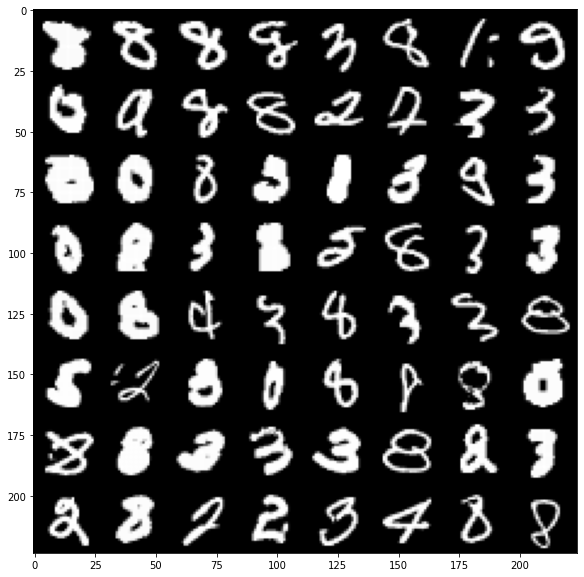

In [11]:
sorted_list = sorted(list(zip(outputs, range(outputs.shape[0]))))
x_bad = x_train[[x[1] for x in sorted_list[:64]]].reshape(8, 28*8, 28)

# let's take a look at the most weird image
plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate(x_bad, axis=1), cmap='gray')

In [47]:
output = None
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mse_prime(y_true, y_pred):
    # could also use y_true.shape[0]
    return (2 * (y_pred - y_true)) / y_true.size

In [84]:
class Layer:
    def __init__(self, in_features, out_features, learning_rate=0.001):
        self.in_features = in_features
        self.out_features = out_features
        self.lr = learning_rate
        self.weights = np.random.rand(self.in_features, self.out_features)
        self.bias = np.empty(self.out_features)
        
    # forward pass
    def forward(self, input):
        self.input = input
        output = self.bias + np.dot(self.input, self.weights)
        # ReLU activation function
        output[output < 0] = 0
        return output
    
    # backward pass
    def backward(self, output_error):
        # dz_dw = self.input # x * in_features
        # dz_db = output_error # x * out_features
        
        weights_grad = np.dot(self.input.T, output_error)
        print(self.input.shape)
        print(output_error.shape)
        print(weights_grad.shape)
        self.weights -= np.multiply(weights_grad, self.lr)
        self.bias -= np.multiply(output_error, self.lr)

In [74]:
class NeuralNet:
    def __init__(self):
        self.l1 = Layer(784, 128)
        self.l2 = Layer(128, 128)
        self.l3 = Layer(128, 10)
        
    def __call__(self, input):
        return self.forward(input)
        
    def forward(self, input):
        output = self.l1.forward(input)
        output = self.l2.forward(output)
        output = self.l3.forward(output)
        return output
    
    def backward(self, output_error):
        self.l1.backward(output_error)
        self.l2.backward(output_error)
        self.l3.backward(output_error)

In [85]:
EPOCHS = 5
batch_size = 64
nn = NeuralNet()

for epoch in range(EPOCHS):
    i = 0
    loss = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = x_train[low: low + batch_size]
        y = y_train[low: low + batch_size]
        output = nn(x)
        output = np.argmax(output, axis = 1)
        loss = mse(y, output)
        loss_prime = mse_prime(y, output)
        nn.backward(loss_prime)
    print(loss)

(64, 784)
(64,)
(784,)


ValueError: operands could not be broadcast together with shapes (784,128) (784,) (784,128) 